In [1]:
# DATA MANIPULATION
import pandas as pd
import numpy as np
import math

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_predict
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
#load data
df = pd.read_pickle(f'../models/all_df.pickle')

#reset row index
df.reset_index(drop=True, inplace=True)
df = df.sort_values('date')
df

,store_nbr,date,sales,onpromotion,city,state,type_stores,cluster,type_holiday,locale,locale_name,oil_price,oil_price_interpolated,transactions
37217,25,2013-01-01,2511.618999,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,0.00,0.00,770.0
0,1,2013-01-02,7417.148000,0,Quito,Pichincha,D,13,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,2111.0
33963,23,2013-01-02,6560.337000,0,Ambato,Tungurahua,D,9,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,1381.0
35640,24,2013-01-02,11018.852996,0,Guayaquil,Guayas,D,1,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,2605.0
37218,25,2013-01-02,5316.224000,0,Salinas,Santa Elena,D,1,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73818,47,2017-08-15,31653.691000,178,Quito,Pichincha,A,14,Holiday,Local,Riobamba,47.57,47.57,3581.0
25041,15,2017-08-15,7946.431000,245,Ibarra,Imbabura,C,15,Holiday,Local,Riobamba,47.57,47.57,1320.0
23365,14,2017-08-15,9342.732000,215,Riobamba,Chimborazo,C,7,Holiday,Local,Riobamba,47.57,47.57,1241.0
72141,46,2017-08-15,22348.414970,163,Quito,Pichincha,A,14,Holiday,Local,Riobamba,47.57,47.57,3197.0


In [3]:

# group the DataFrame by date and sum the sales for each date
sales_by_date = df.groupby('date')['sales'].sum().reset_index()

# create a new DataFrame with only the 'date' and 'sales' columns
df_filtered = sales_by_date[['date', 'sales']]





In [4]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):

    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)

    plt.title(title)
    plt.grid(True)
    plt.show()

In [5]:
# df_filtered = df[(df['store_nbr'] == 1)]
# df_filtered = df[(df['store_nbr'] == 2)]


In [6]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Reshape the 'sales' column into a 2D array
sales_column = df_filtered['sales'].values.reshape(-1, 1)

# Apply the scaling transformation to the 'sales' column using .loc accessor
df_filtered.loc[:, 'sales'] = scaler.fit_transform(sales_column)

In [7]:
df_filtered

,date,sales
0,2013-01-01,0.000000
1,2013-01-02,0.150697
2,2013-01-03,0.109592
3,2013-01-04,0.107455
4,2013-01-05,0.144975
...,...,...
1677,2017-08-11,0.251536
1678,2017-08-12,0.241234
1679,2017-08-13,0.263525
1680,2017-08-14,0.231553


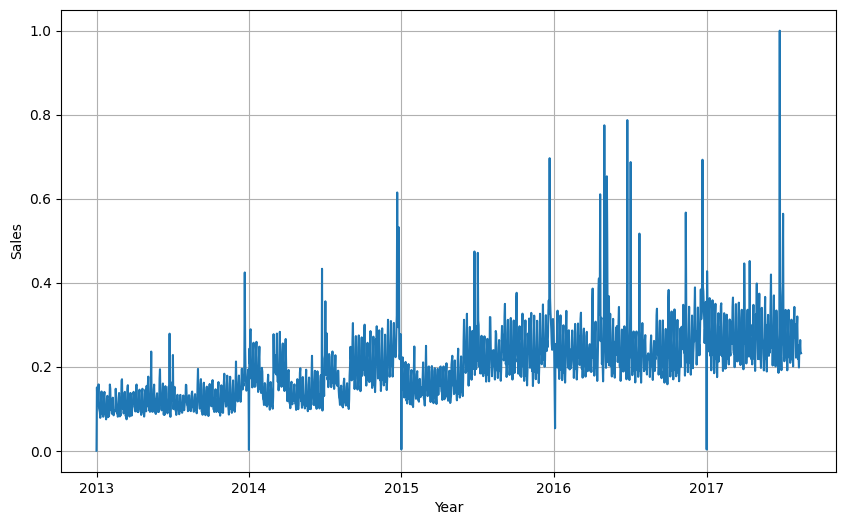

In [8]:
# Convert lists to numpy arrays
time_step = df_filtered['date']
series = df_filtered['sales']
time = np.array(time_step)
series = np.array(series)

# Preview the data
plot_series(time, series, xlabel='Year', ylabel='Sales')

In [9]:
# Define the split time
# split_time = 1400
split_time = 1400

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
# Parameters
window_size = 300
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## 4. use LSTM-CNN

In [12]:
# model_tune = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[window_size, 1]),
#     tf.keras.layers.MaxPooling1D(pool_size=2),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(32),
#     tf.keras.layers.Dense(1)
# ])


In [13]:
# model_tune = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[window_size, 1]),
#     tf.keras.layers.MaxPooling1D(pool_size=2),
#     tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling1D(pool_size=2),
#     tf.keras.layers.LSTM(128, return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

In [14]:
# # # Set the learning rate
# learning_rate = 8e-7

# # # Set the optimizer 
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# # Set the training parameters
# model_LSTM_CNN.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])

# # Train the model
# history = model_LSTM_CNN.fit(train_set,epochs=100)

In [15]:

# # Define the schedule function
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# # Set the initial learning rate
# learning_rate = 8e-7

# # Set the optimizer 
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# # Set the training parameters and include the learning rate scheduler
# model_tune.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# # Train the model with the learning rate scheduler
# history = model_tune.fit(train_set,epochs=100, callbacks=[lr_scheduler])

# # Get the learning rate values and loss values
# lr_values = history.history['lr']
# loss_values = history.history['loss']

# # Plot the loss against the learning rate
# plt.plot(lr_values, loss_values)
# plt.xscale('log')
# plt.xlabel('Learning Rate')
# plt.ylabel('Loss')
# plt.title('Learning Rate vs. Loss')
# plt.show()

In [16]:
model_LSTM_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=[window_size, 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])


In [18]:

model_LSTM_CNN.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

# Train the model
history = model_LSTM_CNN.fit(train_set,epochs=100)

Epoch 1/100


2023-04-24 11:03:20.995316: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


35/35 [==============================] - 4s 66ms/step - loss: 0.0045 - mae: 0.0659
Epoch 2/100
35/35 [==============================] - 2s 59ms/step - loss: 0.0022 - mae: 0.0450
Epoch 3/100
35/35 [==============================] - 2s 57ms/step - loss: 0.0021 - mae: 0.0445
Epoch 4/100
35/35 [==============================] - 2s 57ms/step - loss: 0.0021 - mae: 0.0441
Epoch 5/100
35/35 [==============================] - 2s 59ms/step - loss: 0.0022 - mae: 0.0449
Epoch 6/100
35/35 [==============================] - 2s 58ms/step - loss: 0.0021 - mae: 0.0439
Epoch 7/100
35/35 [==============================] - 2s 58ms/step - loss: 0.0020 - mae: 0.0435
Epoch 8/100
35/35 [==============================] - 2s 58ms/step - loss: 0.0020 - mae: 0.0427
Epoch 9/100
35/35 [==============================] - 2s 60ms/step - loss: 0.0021 - mae: 0.0441
Epoch 10/100
35/35 [==============================] - 2s 60ms/step - loss: 0.0020 - mae: 0.0425
Epoch 11/100
35/35 [==============================] - 2s 59ms

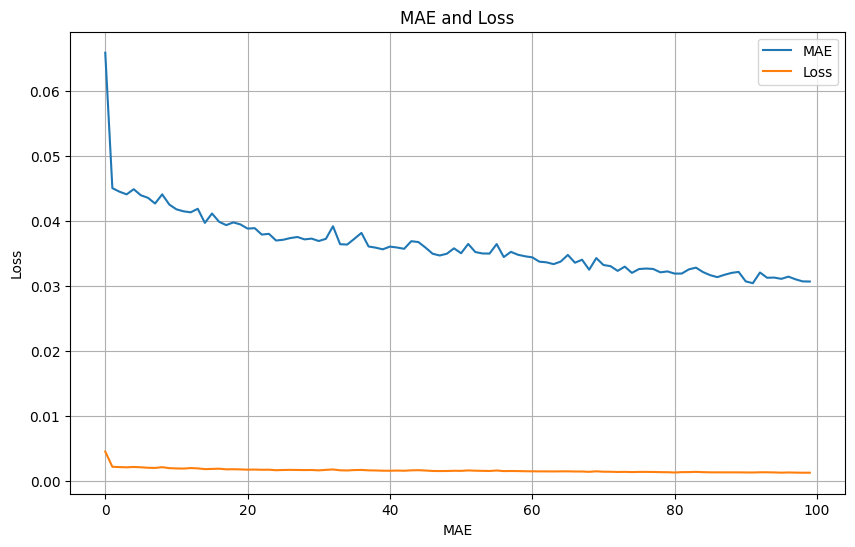

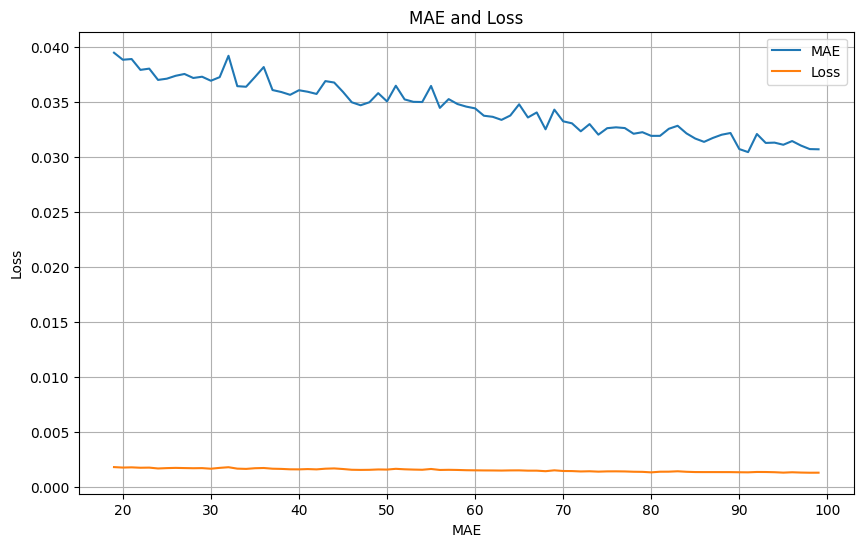

In [19]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

1/1 [==============================] - 0s 14ms/step


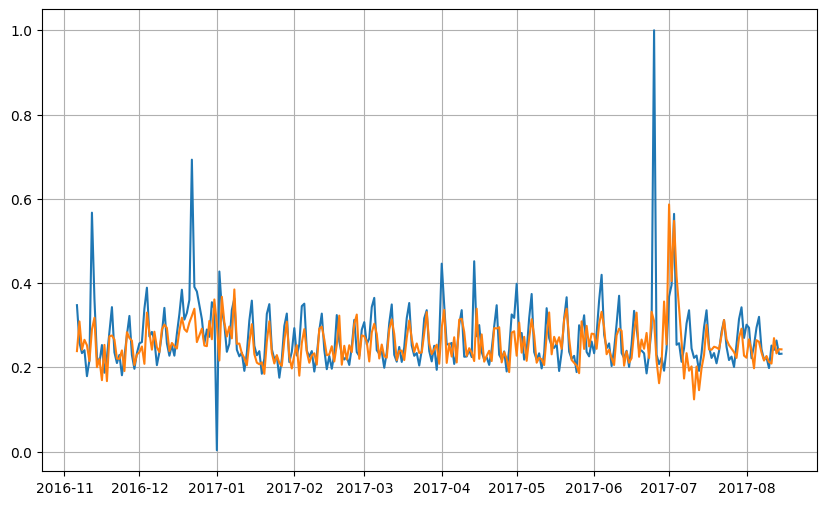

In [20]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_LSTM_CNN.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [21]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.005368595
0.042444926
